In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from itertools import combinations
from scipy.stats import pearsonr, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 14,6

In [2]:
df = pd.read_csv('prep_loan.csv', low_memory=False)

### Multicollinearity and Data Cleaning

In [3]:
num_feat = df.select_dtypes('number').columns

In [4]:
corr = df[num_feat].corr()

In [5]:
m = (corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()

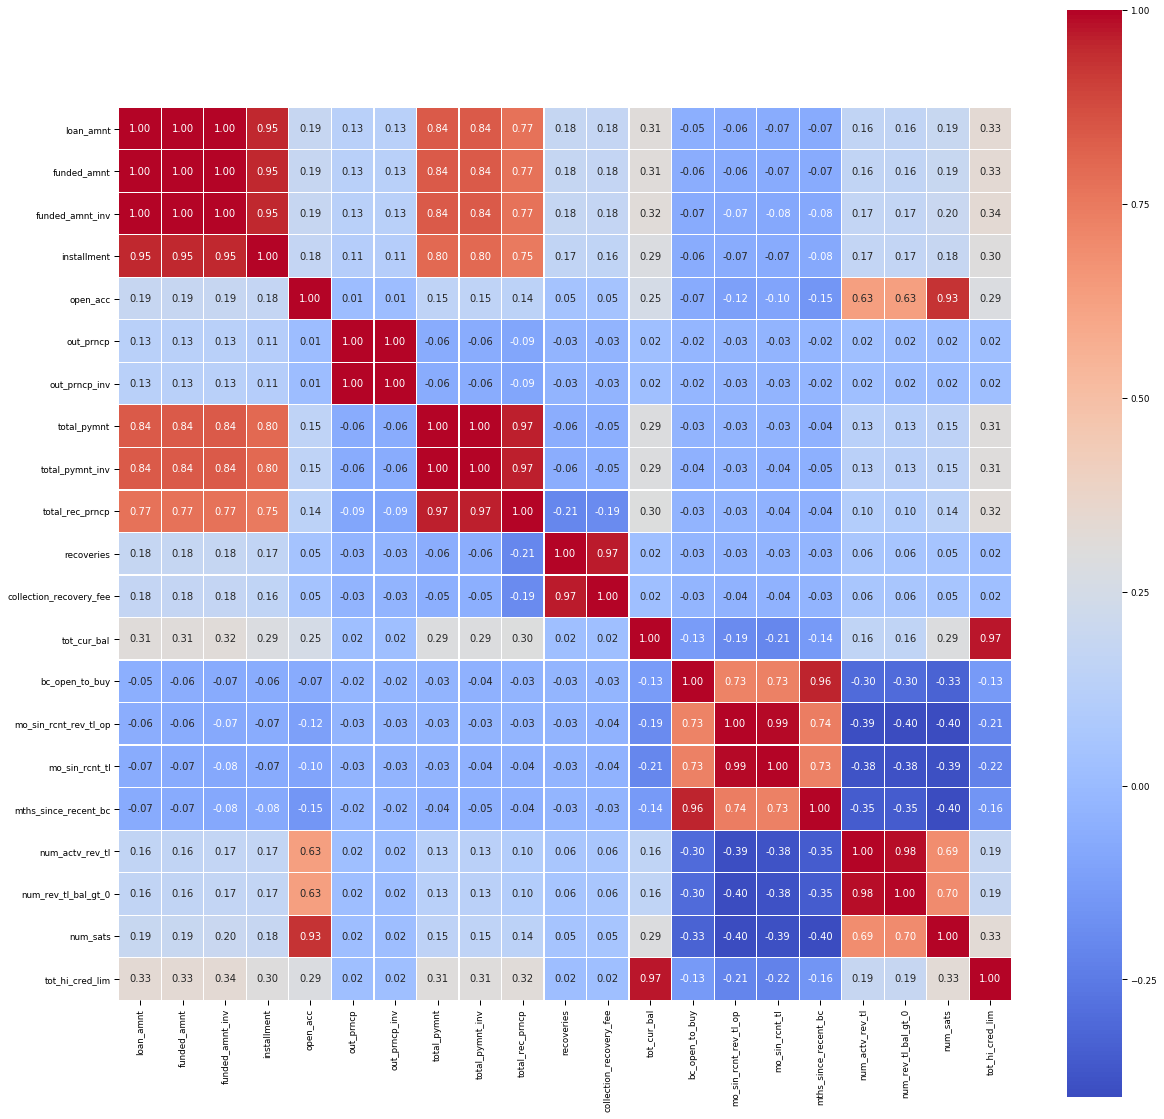

In [6]:
plt.figure(figsize=(20,20))
sns.set_context("paper", font_scale=1)
sns.heatmap(corr.loc[m, m], cbar=True, annot=True, square=True, fmt='.2f',
            annot_kws={'size': 10}, linewidth = 0.1, cmap = 'coolwarm')
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

In [7]:
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(df[comb[0]], df[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

In [8]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

array([['loan_amnt', 'funded_amnt'],
       ['loan_amnt', 'funded_amnt_inv'],
       ['loan_amnt', 'installment'],
       ['funded_amnt', 'funded_amnt_inv'],
       ['funded_amnt', 'installment'],
       ['funded_amnt_inv', 'installment'],
       ['open_acc', 'num_sats'],
       ['out_prncp', 'out_prncp_inv'],
       ['total_pymnt', 'total_pymnt_inv'],
       ['total_pymnt', 'total_rec_prncp'],
       ['total_pymnt_inv', 'total_rec_prncp'],
       ['recoveries', 'collection_recovery_fee'],
       ['tot_cur_bal', 'tot_hi_cred_lim'],
       ['bc_open_to_buy', 'mths_since_recent_bc'],
       ['mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl'],
       ['num_actv_rev_tl', 'num_rev_tl_bal_gt_0']], dtype='<U26')

In [9]:
df = df.drop(np.unique(high_corr_num[:, 1]), axis=1, errors='ignore')

In [10]:
cat_feat = df.select_dtypes('object').columns
df[cat_feat].nunique().sort_values()

term                         2
hardship_flag                2
application_type             2
initial_list_status          2
pymnt_plan                   2
disbursement_method          2
debt_settlement_flag         2
verification_status          3
home_ownership               6
grade                        7
loan_status                  8
emp_length                  12
purpose                     14
sub_grade                   35
addr_state                  51
issue_d                    139
emp_title               378734
dtype: int64

In [11]:
df = df.drop(['emp_title', 'issue_d', 'disbursement_method', 'addr_state', 'initial_list_status', 'debt_settlement_flag'], axis=1, errors='ignore')

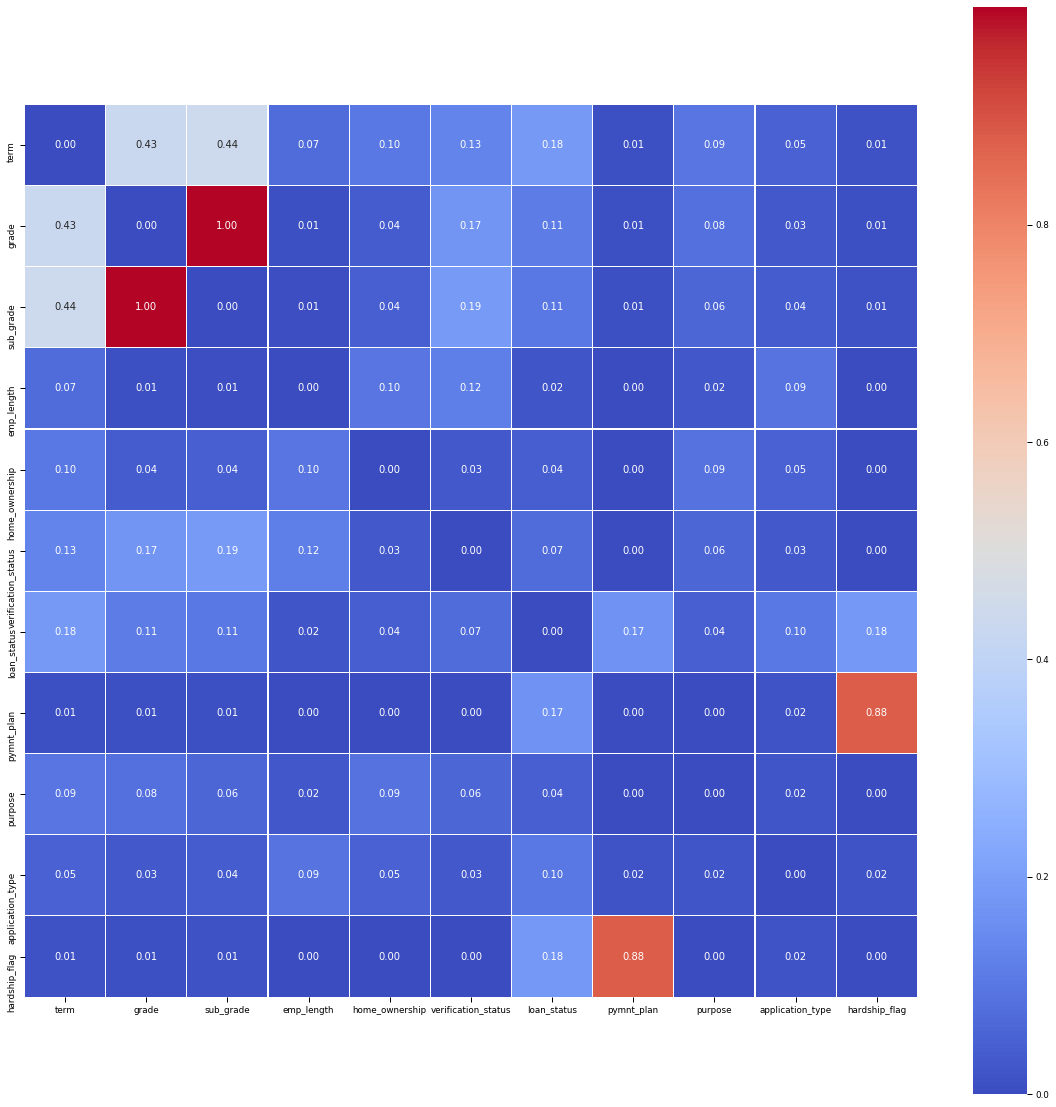

In [12]:
def cramers_corrected_stat(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


cols = list(df.select_dtypes('object').columns)
corrM = np.zeros((len(cols),len(cols)))
for col1, col2 in combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df[col1], df[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
plt.figure(figsize=(20,20))
sns.set_context("paper", font_scale=1)
sns.heatmap(corr, cbar=True, annot=True, square=True, fmt='.2f',
            annot_kws={'size': 10}, linewidth = 0.1, cmap = 'coolwarm')
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

In [13]:
df = df.drop(['sub_grade', 'hardship_flag'], axis=1, errors='ignore')

In [14]:
df.loc[df['loan_status'] == 'Fully Paid', 'loan_type'] = 1
df.loc[df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid', 'loan_type'] = 1
df.loc[df['loan_status'] == 'Late (31-120 days)', 'loan_type'] = 0
df.loc[df['loan_status'] == 'In Grace Period', 'loan_type'] = 0
df.loc[df['loan_status'] == 'Charged Off', 'loan_type'] = 0
df.loc[df['loan_status'] == 'Late (16-30 days)', 'loan_type'] = 0
df.loc[df['loan_status'] == 'Default', 'loan_type'] = 0
df.loc[df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off', 'loan_type'] = 0

In [15]:
df = df.drop(['loan_status'], axis=1, errors='ignore')

In [16]:
num_feat = df.select_dtypes('number').columns

In [17]:
num_feat

Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'out_prncp', 'total_pymnt', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_tl_120dpd_2m', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'total_bal_ex_mort', 'total_bc_limit', 'tot

In [18]:
df = df.drop(['recoveries', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'tot_coll_amt', 'out_prncp',
       'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'out_prncp', 'total_pymnt', 'total_rec_int',
       'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'application_type',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_tl_120dpd_2m', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'tax_liens', 'total_rec_late_fee',
       'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit'], axis=1, errors='ignore')

In [19]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan',
       'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mths_since_recent_inq',
       'pub_rec_bankruptcies', 'loan_type'],
      dtype='object')

In [20]:
df = pd.get_dummies(df, drop_first=True)

In [21]:
df.columns

Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'acc_now_delinq', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mths_since_recent_inq', 'pub_rec_bankruptcies',
       'loan_type', 'term_ 60 months', 'grade_B', 'grade_C', 'grade_D',
       'grade_E', 'grade_F', 'grade_G', 'emp_length_1 year',
       'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years',
       'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years',
       'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years',
       'emp_length_< 1 year', 'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'pymnt_plan_y', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement'

### Classification

In [22]:
traindata, testdata = train_test_split(df, stratify=df['loan_type'], test_size=.2, random_state=42)
testdata.reset_index(drop=True, inplace=True)
traindata.reset_index(drop=True, inplace=True)

In [23]:
sc = StandardScaler()
X = traindata.drop('loan_type', axis=1)
y = traindata['loan_type']
num_feat = X.select_dtypes('number').columns
X[num_feat] = sc.fit_transform(X[num_feat])

/home/alvaro/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/alvaro/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [24]:
X_test = testdata.drop('loan_type', axis=1)
y_test = testdata['loan_type']
num_feat = X_test.select_dtypes('number').columns
X_test[num_feat] = sc.fit_transform(X_test[num_feat])

/home/alvaro/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/alvaro/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [25]:
model = LogisticRegression(solver='lbfgs')
model.fit(X, y)
predict = model.predict(X_test)

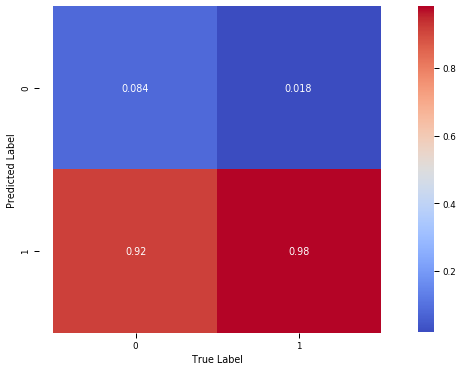

In [26]:
fig, axes = plt.subplots(figsize=(8,6))
cm = confusion_matrix(y_test, predict).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='coolwarm');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.axis('equal')
plt.show()

In [28]:
#balanceando o modelo

y_bad = traindata[traindata['loan_type'] == 0]
good = traindata[traindata['loan_type'] == 1].sample(n=len(y_bad), random_state=42)
new_traindata = y_bad.append(good) 

X = new_traindata.drop('loan_type', axis=1)
y = new_traindata['loan_type']

In [29]:
num_feat = X.select_dtypes('number').columns
X[num_feat] = sc.fit_transform(X[num_feat])

/home/alvaro/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/alvaro/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [30]:
model = LogisticRegression(solver='lbfgs')
model.fit(X, y)
predict = model.predict(X_test)

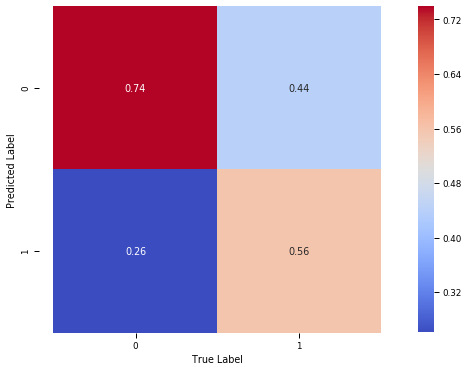

In [31]:
fig, axes = plt.subplots(figsize=(8,6))
cm = confusion_matrix(y_test, predict).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='coolwarm');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.axis('equal')
plt.show()

### Clustering

In [33]:
X_std = StandardScaler().fit_transform(df)
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_std)

/home/alvaro/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/alvaro/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


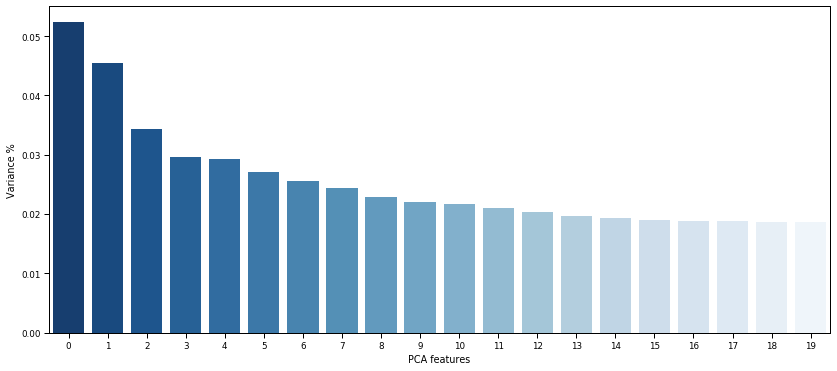

In [51]:
features = list(range(pca.n_components_))
sns.barplot(features, pca.explained_variance_ratio_, palette="Blues_r")
plt.xlabel('PCA features')
plt.ylabel('Variance %')
plt.xticks(features)
plt.show()

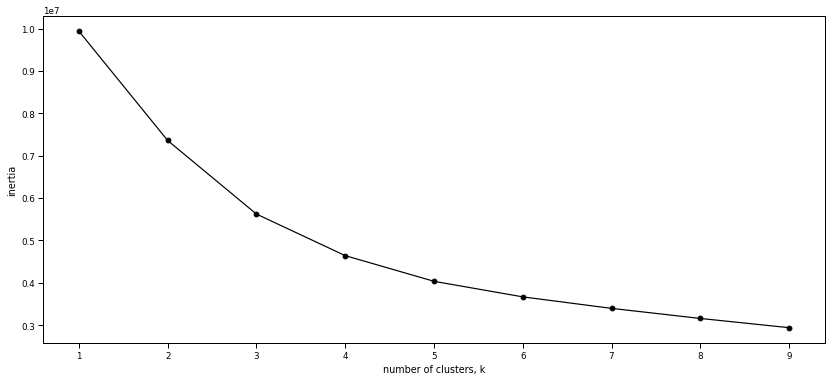

In [61]:
PCA_components = pd.DataFrame(principalComponents)
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:3])
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [66]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X_std)
PCA_components = pd.DataFrame(principalComponents)

In [67]:
model = KMeans(n_clusters=4)
model.fit(PCA_components)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [71]:
y_kmeans = model.predict(PCA_components)

In [75]:
PCA_sample = PCA_components.sample(n=50000, random_state=42)
y_sample = y_kmeans[PCA_sample.index]

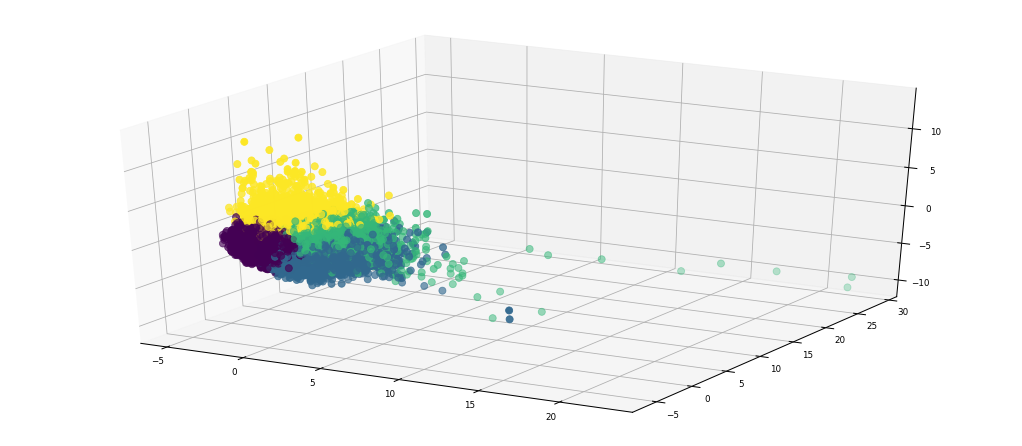

In [78]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(PCA_sample.iloc[:, 0], PCA_sample.iloc[:, 1], PCA_sample.iloc[:, 2], c=y_sample, s=50, cmap='viridis')
plt.show()